In [1]:
# import library
# ========= choice of library ====
import tensorflow as tf
import matplotlib 
# configure backend here
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [2]:
# input the mnist data
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((60000,28,28,1))
test_batch = np.zeros((10000,28,28,1))

for x in range(len(x_data)):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)
for x in range(len(y_data)):
    test_batch[x,:,:,:] = np.expand_dims(resize(y_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(60000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
1.0
0.0
(10000, 10)
1.0
0.0


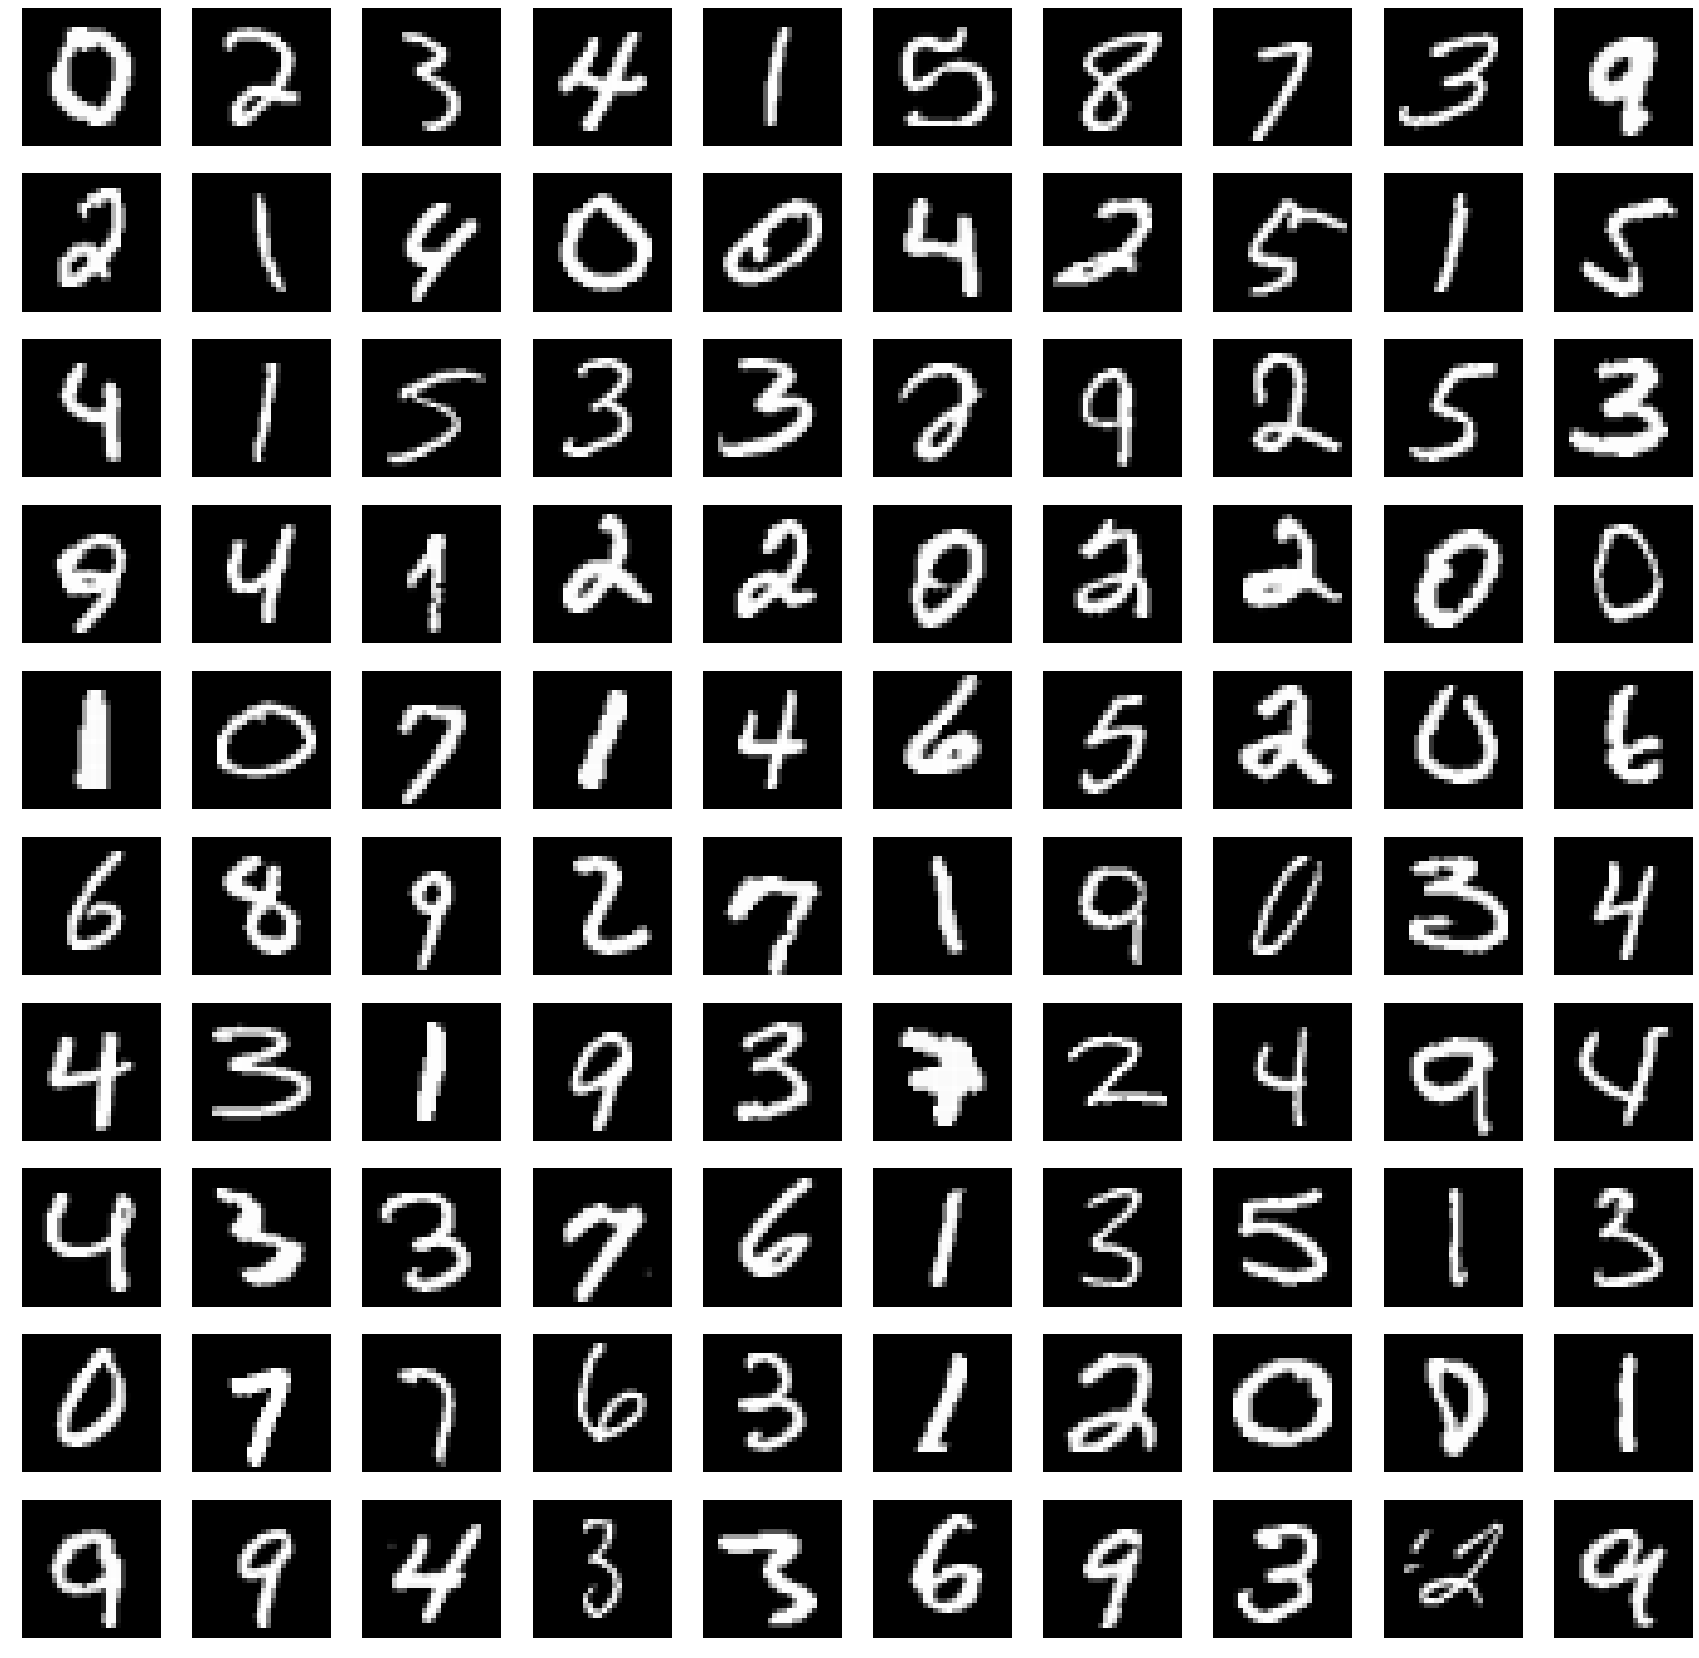

In [3]:
# view random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(30, 30))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

# Func: Fully Connected Layer
class FNN():
    """Fully Connected Neural Network Implemented in Tensorflow

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.
    special_init : type
        Description of parameter `special_init`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float64,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w


class CNN():
    """Convolutional Layer in Tensorflow

    Parameters
    ----------
    k : type
        Description of parameter `k`.
    inc : type
        Description of parameter `inc`.
    out : type
        Description of parameter `out`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    act
    d_act

    """

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

class CNN_Trans():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,output_shape,stride=1,padding='SAME'):
        self.input   = input
        self.layer  = tf.nn.conv2d_transpose(
            input,self.w,output_shape=[batch_size,output_shape,output_shape,self.w.shape[2].value],
            strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride_grad=1,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_middle,
            filter_sizes = self.w.shape,out_backprop = grad_part_3,
            strides=[1,stride_grad,stride_grad,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d(
            input=grad_middle,filter = self.w,strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))

        return grad_pass,update_w
    
class tf_pca_layer():
    
    def __init__(self,n_components):
        self.n_components = tf.Variable(n_components)
    
    def feedforward(self,input):
        self.input = input
        self.cov = tf.matmul(self.input,tf.transpose(self.input)) / (input.shape[0].value-1)
        self.eigval,self.pc = tf.linalg.eigh(self.cov)
        self.pc_projection = self.pc[:,-self.n_components:]
        self.layer = tf.matmul(tf.transpose(self.pc_projection),input)
        return self.layer
    
    def backprop(self,grad):
        mat_shape = self.input.shape[0].value
        d_pc_project = tf.transpose(tf.matmul(grad,tf.transpose(self.input)))
        diff = mat_shape - self.n_components
        added_mat = tf.zeros([mat_shape,diff],dtype=tf.float64)
        d_pc = tf.concat([d_pc_project,added_mat],1)
        E = tf.matmul(tf.ones([mat_shape,1],dtype=tf.float64),tf.transpose(self.eigval)[tf.newaxis,:]) - \
            tf.matmul(self.eigval[:,tf.newaxis],tf.ones([1,mat_shape],dtype=tf.float64))
        F = 1.0/(E + tf.eye(mat_shape,dtype=tf.float64)) - tf.eye(mat_shape,dtype=tf.float64)
        d_cov = tf.matmul(tf.linalg.inv(tf.transpose(self.pc)),
                tf.matmul(F * (tf.matmul(tf.transpose(self.pc),d_pc)),tf.transpose(self.pc)))
        d_x = tf.matmul(self.pc_projection,grad) + \
              (tf.matmul(d_cov,self.input) + tf.matmul(tf.transpose(d_cov),self.input))/(mat_shape-1)
        return d_x
    
class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.05,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layer)
        
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[:,tf.newaxis] * self.w
        grad = self.sym_decorrelation(grad_w)
        
        update_w = []
        
        # ==== Correct Method of Weight Update ====
#         update_w.append(tf.assign(self.w,grad))
        
        # ==== Wrong (gradient ascent) Method of Weight Update ====
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat * 0.01 *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w
    
class tf_mean_layer():
    
    def __init__(self):
        pass
    
    def feedforward(self,input):
        self.mean = tf.reduce_mean(input,1)
        return input-self.mean[:,tf.newaxis]
    
    def backprop(self,grad):
        return grad * (1 + 1.0/grad.shape[0].value)

In [5]:
# class hyper and graph
num_epcoch = 100; learning_rate = 0.0008; batch_size = 100; print_size = 10
beta1,beta2,adam_e = 0.9,0.999,1e-8
lamda = 0.0001

l1 = CNN(3,1,6)
l2 = CNN(3,6,9)
latent = FNN(441,441,act=tf_atan,d_act=d_tf_atan)
l3 = CNN_Trans(3,6,9)
l4 = CNN_Trans(3,1,6,act=tf_sigmoid,d_act=d_tf_sigmoid)

x = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float64)
group_matrix = tf.placeholder(shape=[441,441],dtype=tf.float64)

layer1 = l1.feedforward(x,stride=2)
layer2 = l2.feedforward(layer1,stride=2)
layer2_reshape = tf.reshape(layer2,[batch_size,-1])

latent_layer = latent.feedforward(layer2_reshape)
# group_layer = tf.matmul(tf.transpose(latent_layer),latent_layer)
latent_reshape = tf.reshape(latent_layer,[batch_size,7,7,9])

layer3 = l3.feedforward(latent_reshape,output_shape=14,stride=2)
layer4 = l4.feedforward(layer3,output_shape=28,stride=2)

recon_cost = tf.reduce_mean(tf.square(layer4-x))
# group_cost = tf.reduce_sum(tf.sqrt(group_matrix * group_layer + adam_e))
total_cost = recon_cost

grad_4,grad_4_up = l4.backprop( (layer4-x)/batch_size ,stride=2,stride_grad=2)
grad_3,grad_3_up = l3.backprop(grad_4,stride=2,stride_grad=2)

grad_3_reshape = tf.reshape(grad_3,[batch_size,-1])
grad_latent,grad_latent_up = latent.backprop(grad_3_reshape)

grad_latent_reshape = tf.reshape(grad_latent,[batch_size,7,7,9])
grad_2,grad_2_up = l2.backprop(grad_latent_reshape,stride=2)
grad_1,grad_1_up = l1.backprop(grad_2,stride=2)
grad_up = grad_4_up + grad_3_up + grad_latent_up + grad_2_up + grad_1_up

iter : 0 index: 59900 recon mean: 0.026688470904386984
----------


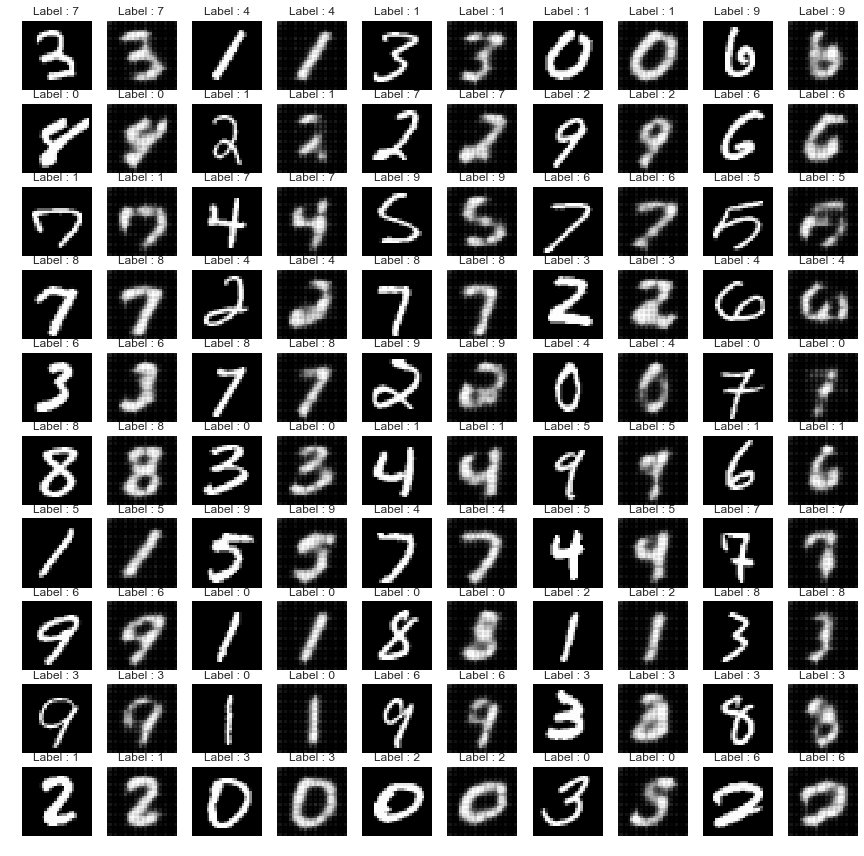

iter : 10 index: 59900 recon mean: 0.0060810801317154625
----------


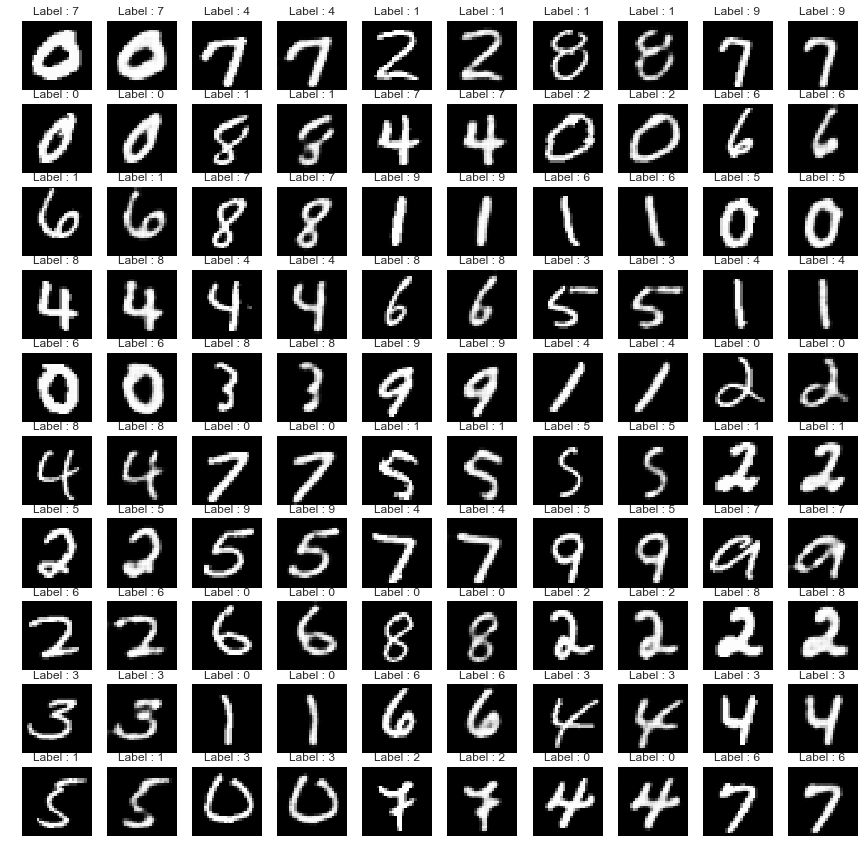

iter : 20 index: 59900 recon mean: 0.0036113134958550936
----------


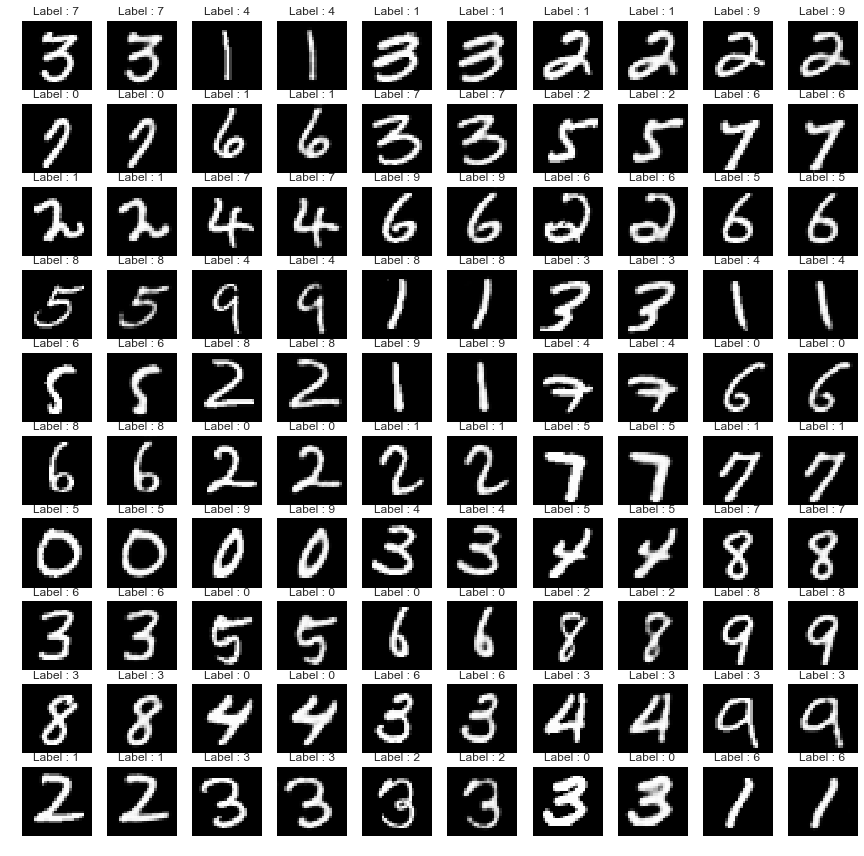

iter : 30 index: 59900 recon mean: 0.0030070892463125607
----------


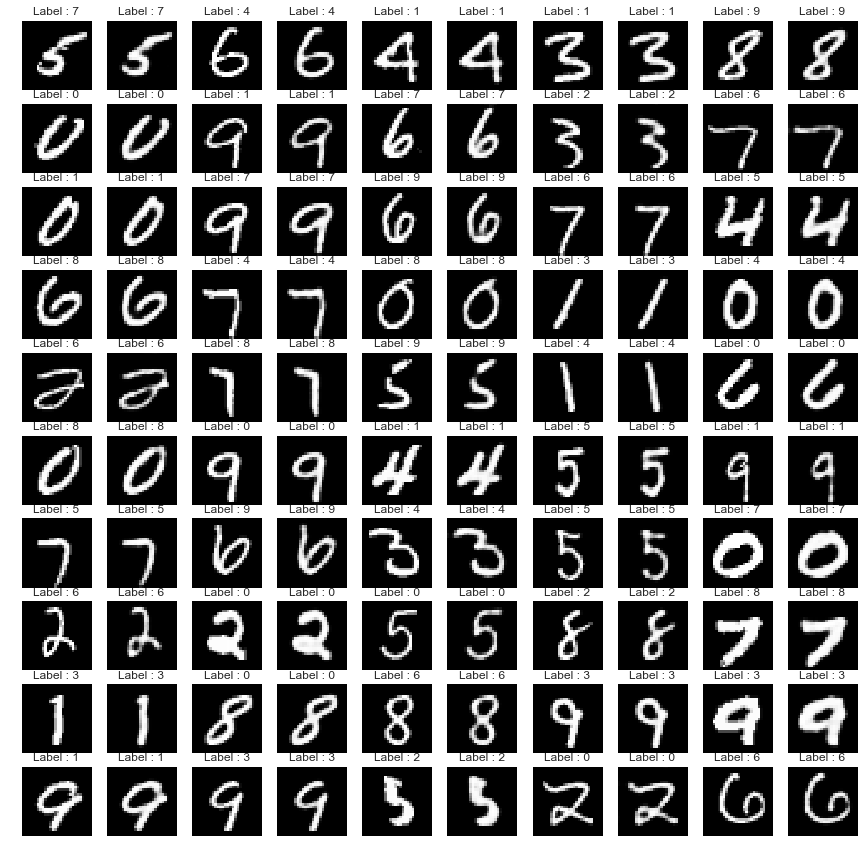

iter : 40 index: 59900 recon mean: 0.0022323934719007917
----------


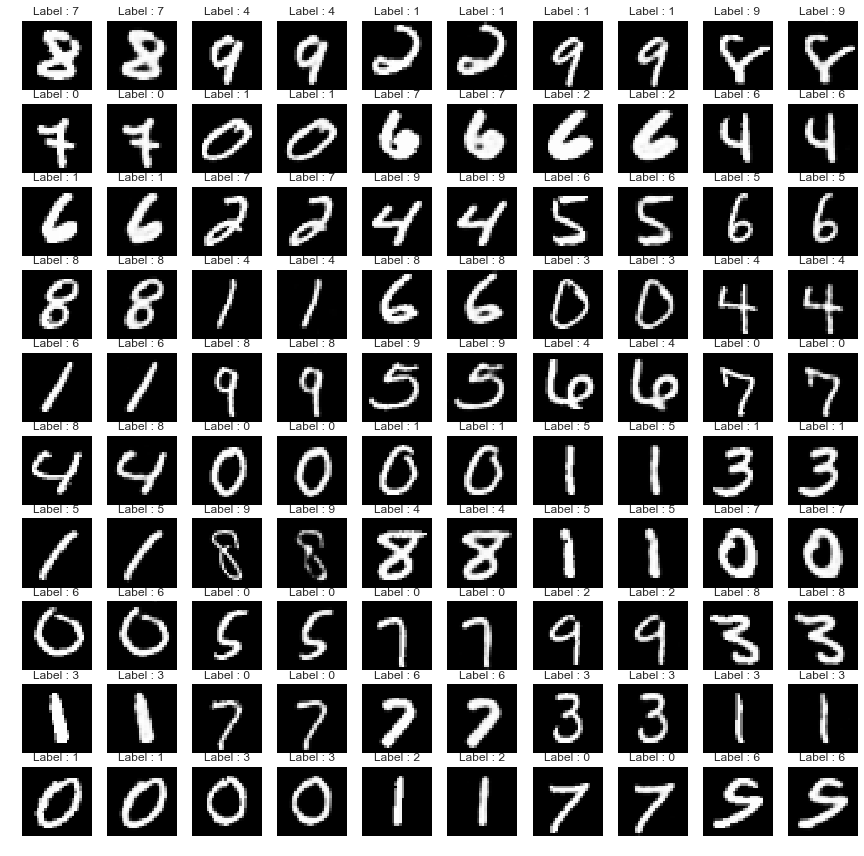

iter : 50 index: 59900 recon mean: 0.0020506419620403725
----------


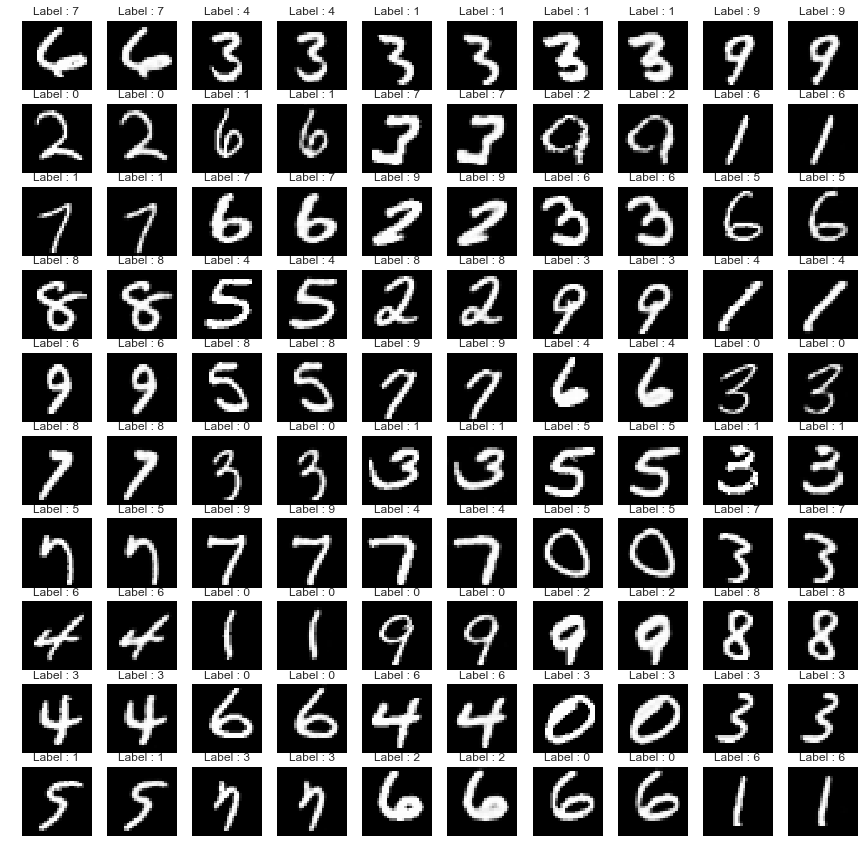

iter : 60 index: 59900 recon mean: 0.0019190862521065825
----------


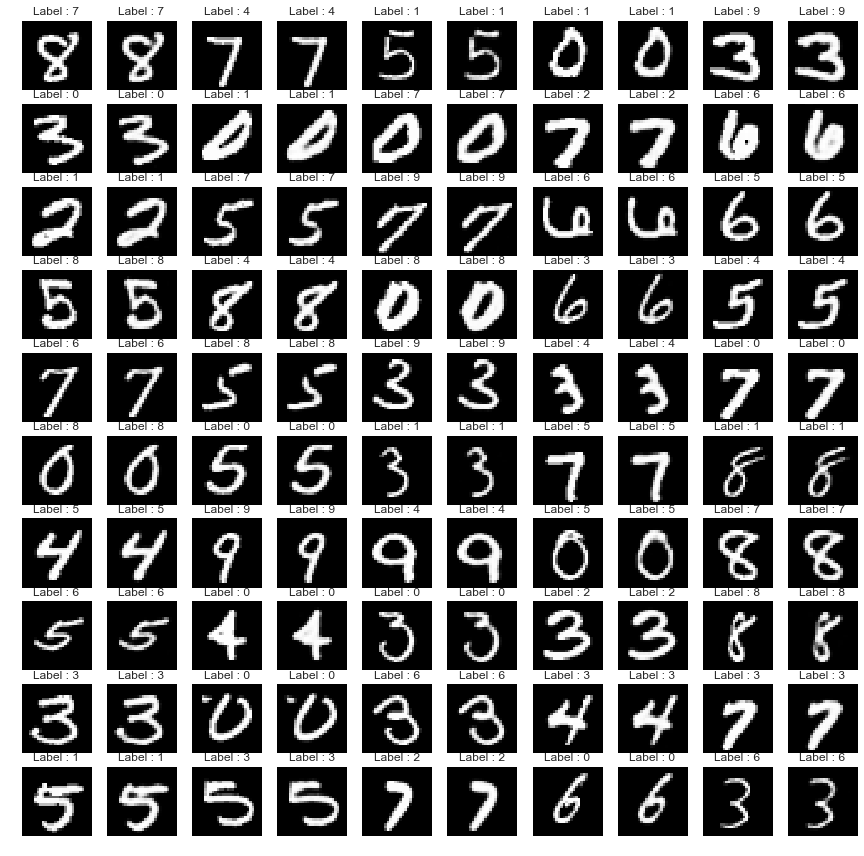

iter : 70 index: 59900 recon mean: 0.0016998165560103465
----------


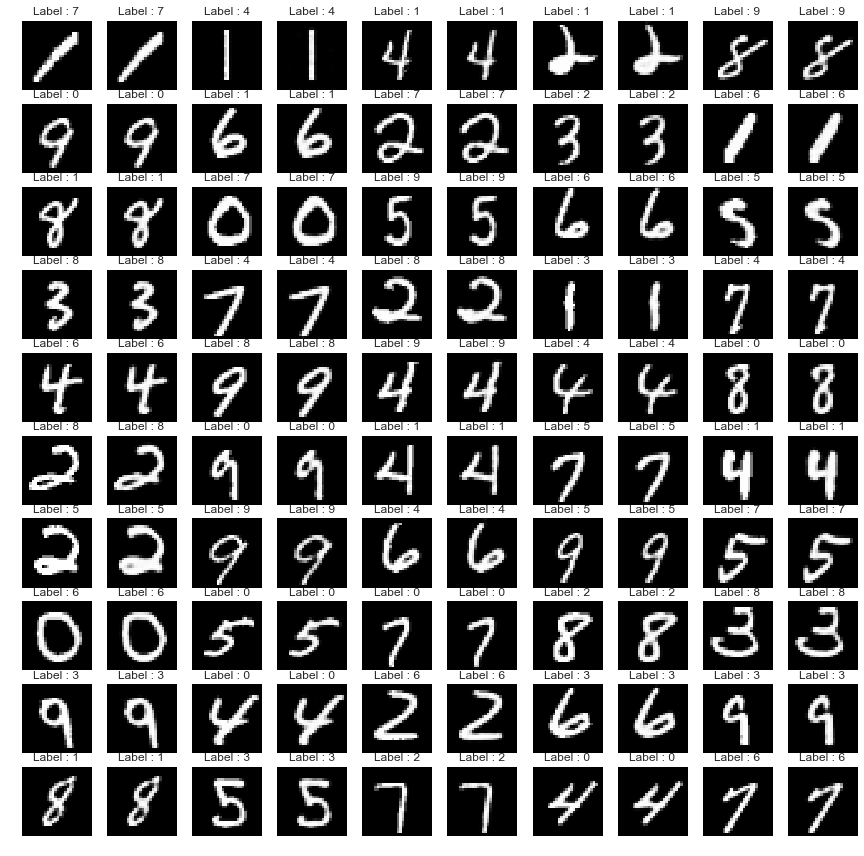

iter : 80 index: 59900 recon mean: 0.0015824457570986835
----------


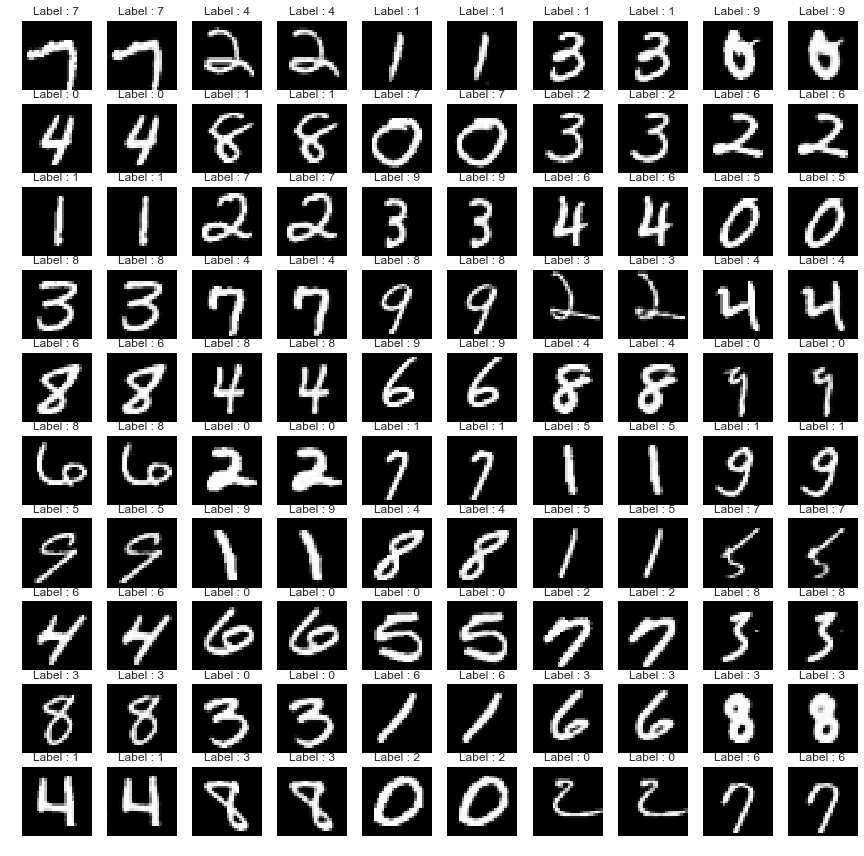

iter : 90 index: 59900 recon mean: 0.0015838071467716179
----------


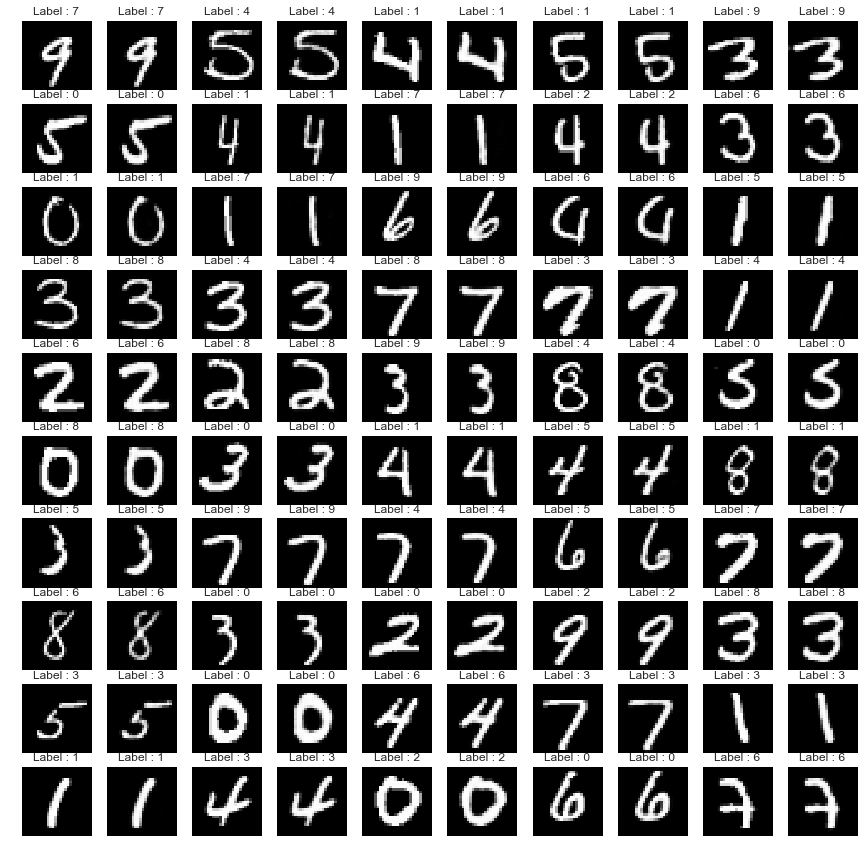

iter : 99 index: 59900 recon mean: 0.0015544825620095934

In [8]:
# start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

results_for_animation = []
for iter in range(num_epcoch):
    train_batch = shuffle(train_batch)
    for current_batch_index in range(0,len(train_batch),batch_size):
        current_train_data = train_batch[current_batch_index:current_batch_index+batch_size,:,:,:]
        sess_results = sess.run([total_cost,grad_up],feed_dict={x:current_train_data})
        sys.stdout.write("\r" + 
                         'iter : ' + str(iter) + 
                         ' index: '+ str(current_batch_index) +
                         " recon mean: " + str(sess_results[0]) ) 
        sys.stdout.flush()
        
    # show mid results     
    if iter % print_size == 0: 
        print('\n----------')
        sample_data = sess.run(layer4,feed_dict={x:current_train_data})
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 10
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 == 0 :
                plt.imshow(np.squeeze(sample_data[i-2]),cmap='gray')
                plt.title("Label : "+str(np.argmax(train_label[i-2])))
            else:
                plt.imshow(np.squeeze(current_train_data[i-1]),cmap='gray')
                plt.title("Label : "+str(np.argmax(train_label[i-1])))
            plt.axis('off')
        plt.show()    

In [ ]:
# 


16


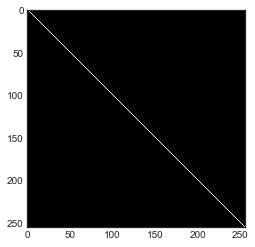

(256, 16, 16)


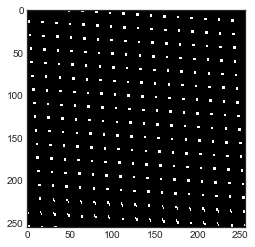

In [9]:
# group matrix
temp = np.zeros((11,11))
donutDim = int(np.floor(np.sqrt(temp.flatten().shape[0])))
donutDim = 16

print(donutDim)
groupMatrix = np.zeros((256, donutDim, donutDim))
np.fill_diagonal(groupMatrix.reshape((256,256)),1.0)
plt.imshow(groupMatrix.reshape((256,256)),cmap='gray')
plt.show()
groupMatrix = np.zeros((256, donutDim, donutDim))

groupNum = 0
poolDim = 3
for row in range(0,donutDim):
    for col in range(0,donutDim): 
        groupMatrix[groupNum, 0:poolDim, 0:poolDim] = 1
        groupNum = groupNum + 1
        groupMatrix = np.roll(groupMatrix,[0,0,-1])
#     groupMatrix = np.roll(groupMatrix,[0,-1,0])

# groupNum = 1;
# for row = 1:donutDim
#     for col = 1:donutDim
#         groupMatrix(groupNum, 1:poolDim, 1:poolDim) = 1;
#         groupNum = groupNum + 1;
#         groupMatrix = circshift(groupMatrix, [0 0 -1]);
#     end
#     groupMatrix = circshift(groupMatrix, [0 -1, 0]);
# end
print(groupMatrix.shape)
groupMatrix = groupMatrix.T.reshape((256,256)).T
plt.imshow(groupMatrix,cmap='gray')
plt.show()

In [10]:
# use high level api approach pca kpca and FastICA
print(train_batch.shape)
from sklearn.decomposition import PCA,KernelPCA,FastICA
sk_pca = PCA(100)
sk_KernelPCA = KernelPCA(100)
sk_FastICA = FastICA(100)

train_batch_reshape = train_batch.reshape(60000,-1)
sk_pca_data = sk_pca.fit_transform(train_batch_reshape.T).T
sk_kpca_data = sk_KernelPCA.fit_transform(train_batch_reshape.T).T
sk_fastica_data = sk_FastICA.fit_transform(train_batch_reshape.T).T
print(sk_pca_data.shape)
print(sk_kpca_data.shape)
print(sk_fastica_data.shape)

(60000, 28, 28, 1)
(100, 784)
(100, 784)
(100, 784)


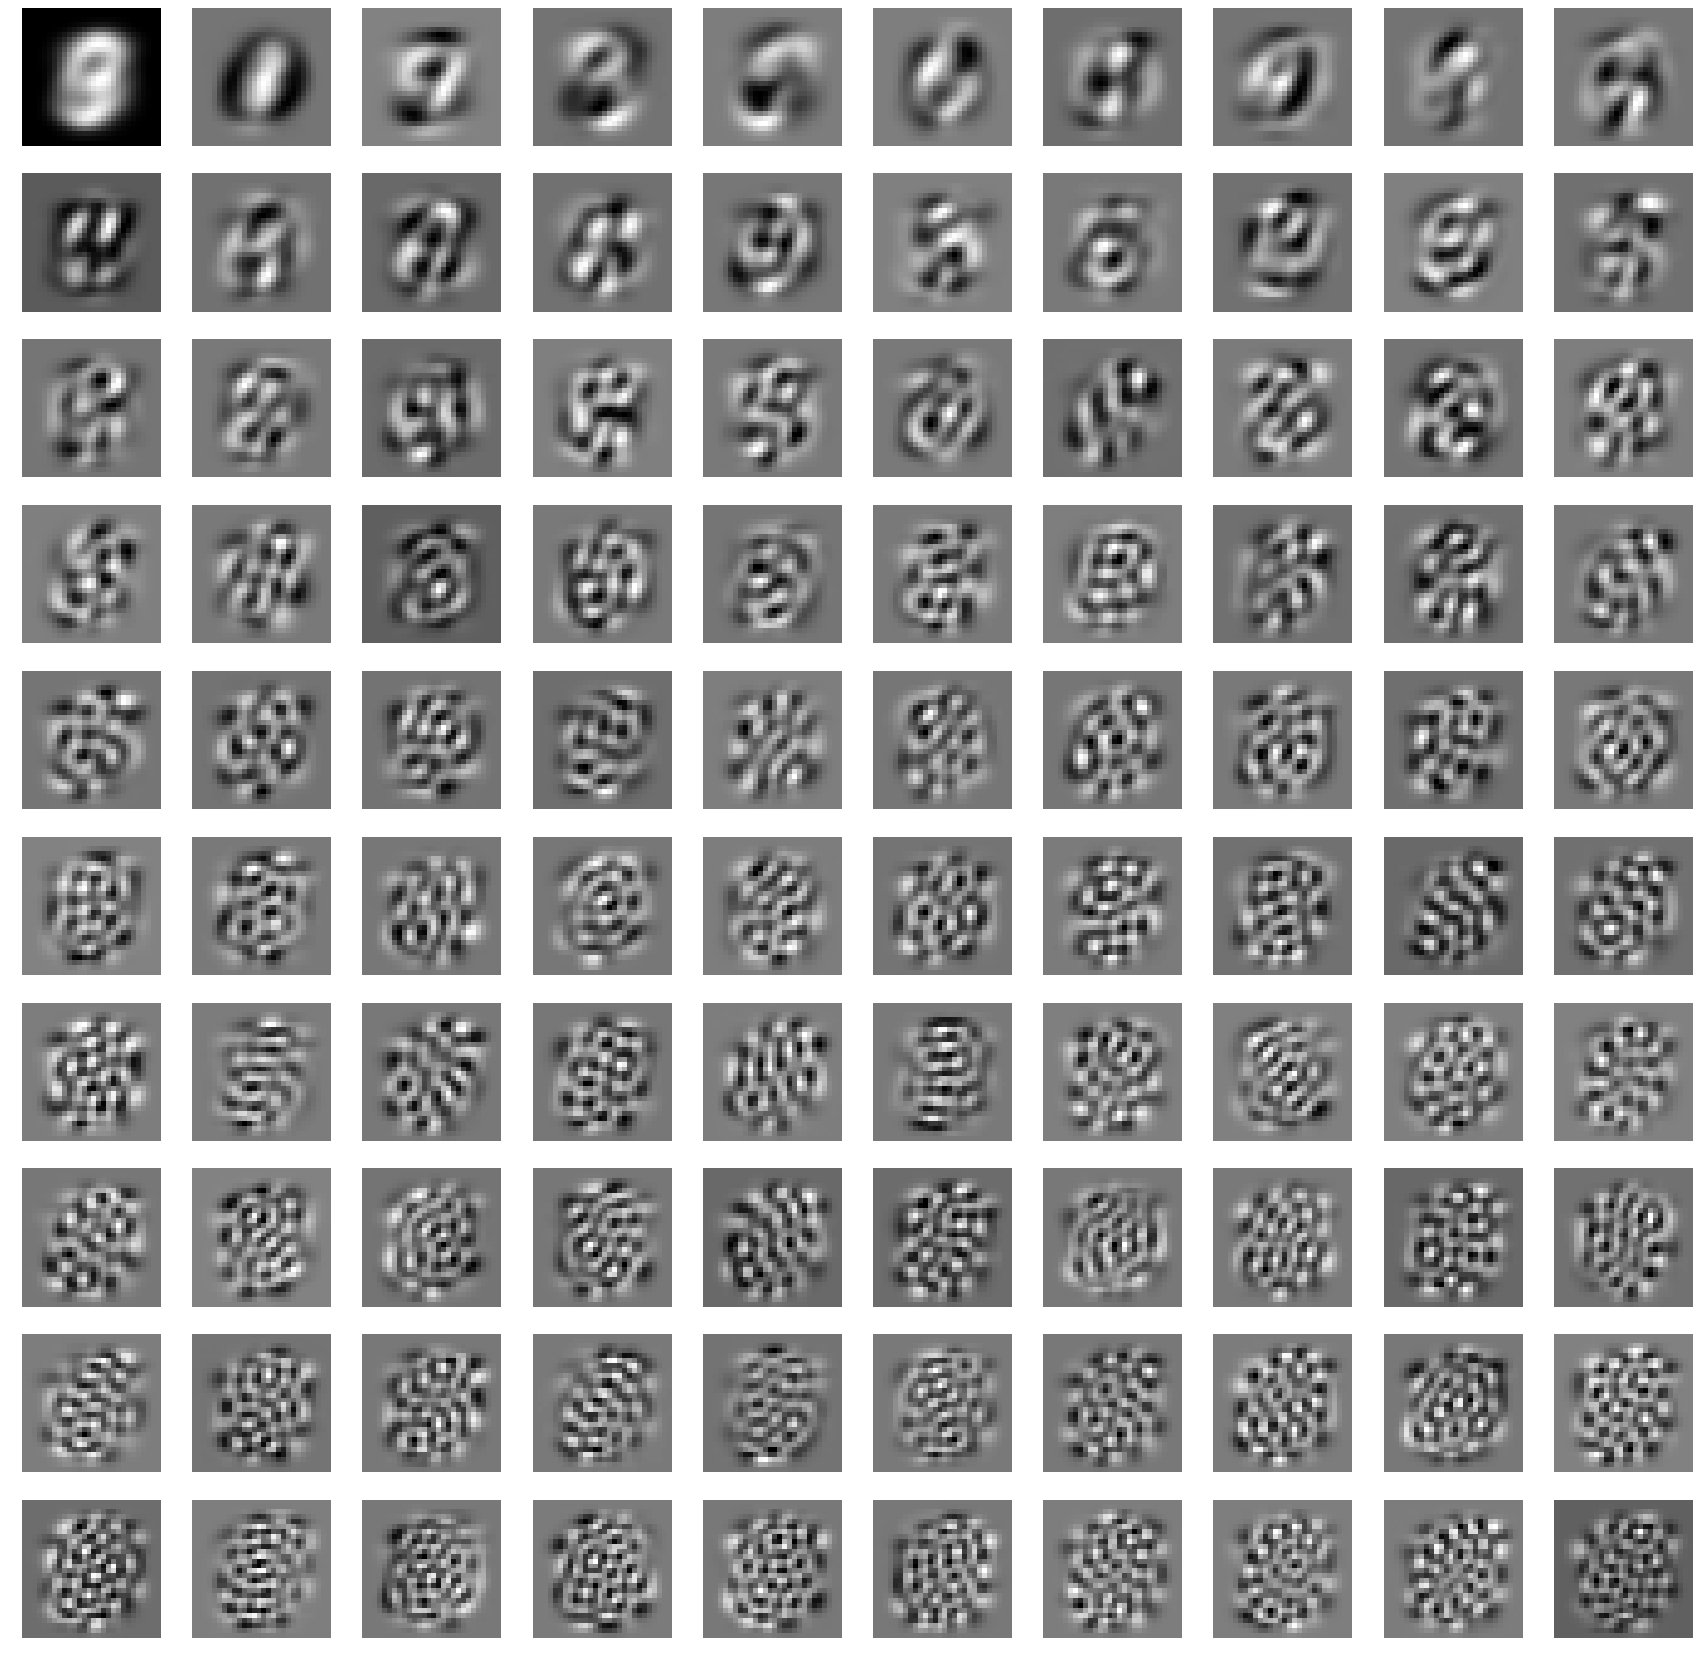

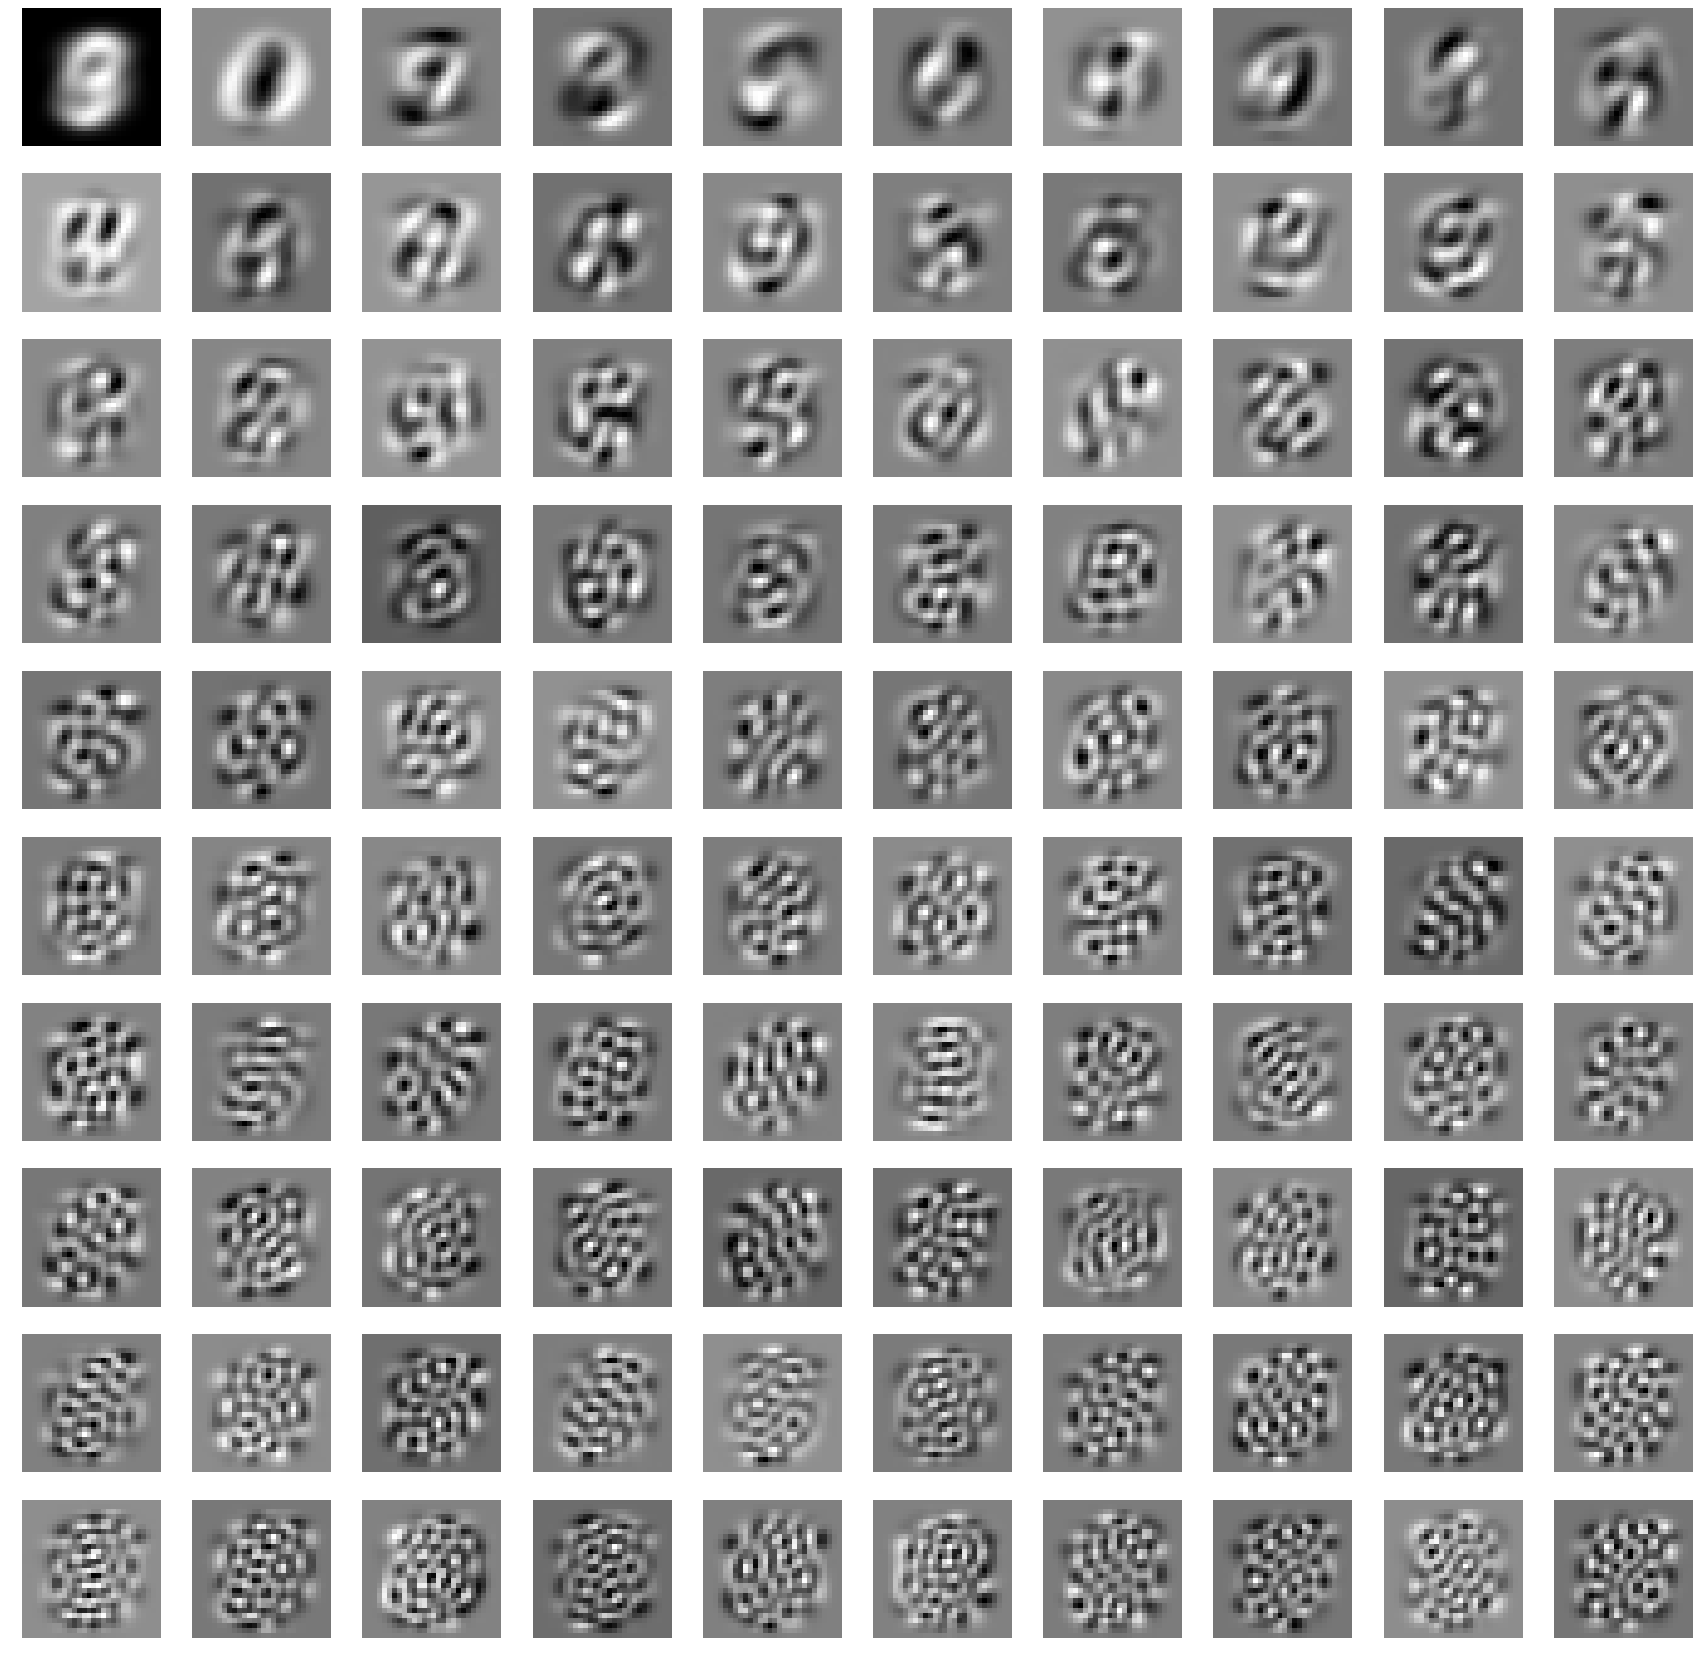

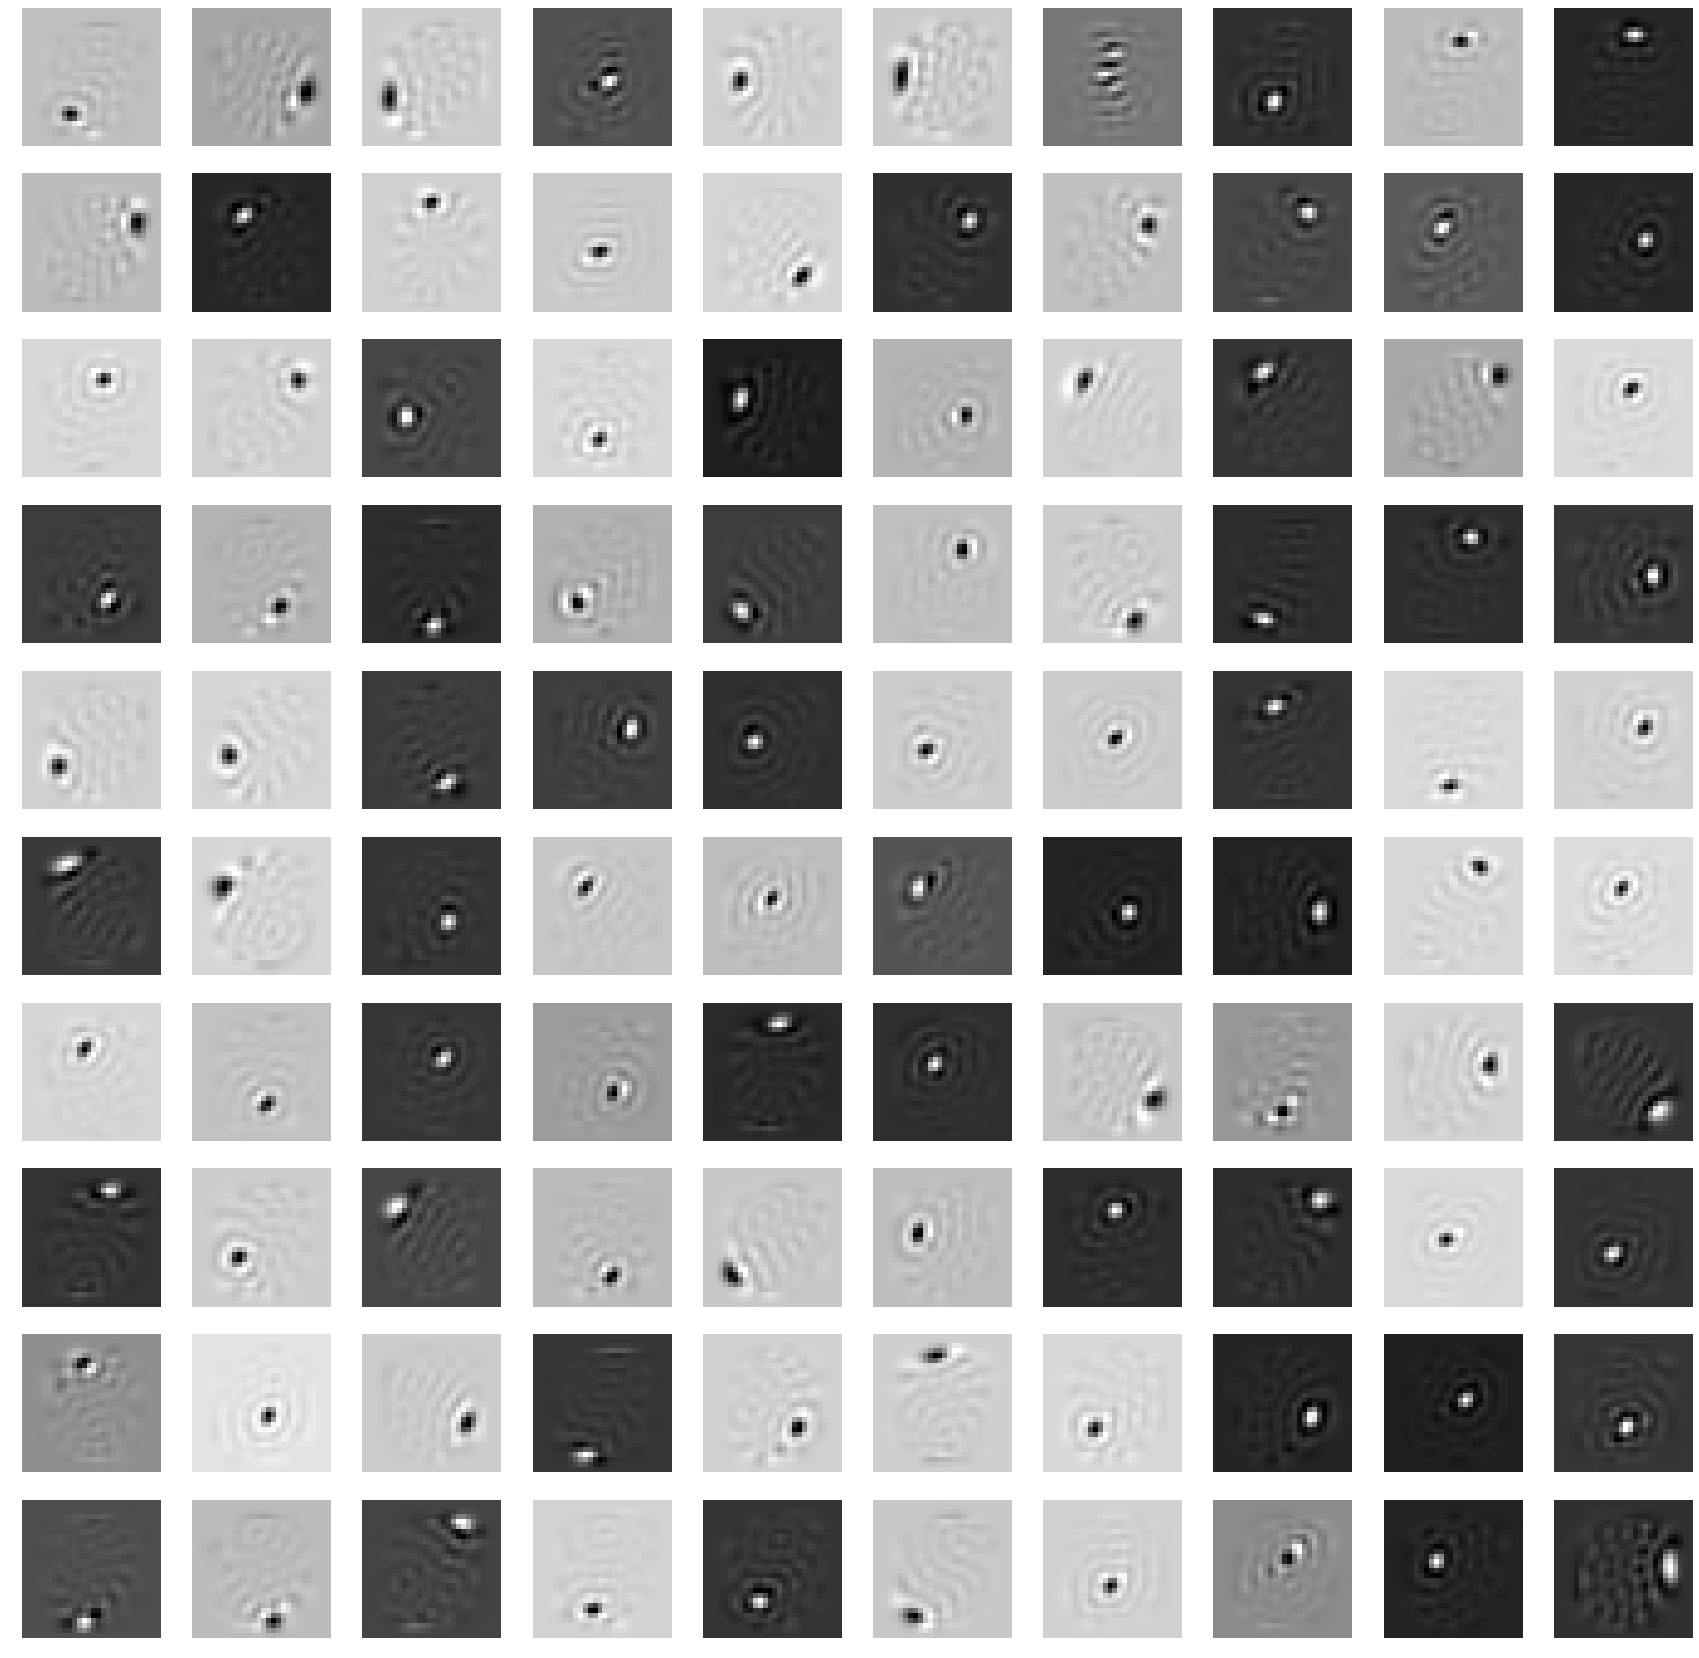

In [11]:
# view the high level results
fig=plt.figure(figsize=(30, 30))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(sk_pca_data[i-1]).reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()
fig=plt.figure(figsize=(30, 30))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(sk_kpca_data[i-1]).reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()
fig=plt.figure(figsize=(30, 30))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(sk_fastica_data[i-1]).reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
! git all-go

[master 5313e91b] s
 2 files changed, 1049 insertions(+), 1271 deletions(-)
 rewrite Understanding_Concepts/topo/a topo.ipynb (78%)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   db572505..5313e91b  master -> master


In [14]:
! git all-go && start .

[master db572505] s
 2 files changed, 464 insertions(+), 42 deletions(-)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   f44c181b..db572505  master -> master
